In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh 
from bokeh.plotting import figure, row
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import viridis
from bokeh.models.annotations import Label
import pandas as pd, numpy as np
from bokeh.io import output_notebook, show
sns.set_theme()
output_notebook()

/global/cfs/cdirs/m3443/usr/pmtuan/conda/exatrkx_hsf/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

In [2]:
filter_event_file = '/global/cfs/cdirs/m3443/usr/pmtuan/Tracking-ML-Exa.TrkX/run/filter/datasets/filter_processed/test/1005'
filter_graph = torch.load(filter_event_file)

ml_event_file = filter_event_file.replace('filter_processed', 'metric_learning_processed')
ml_graph = torch.load(ml_event_file)

filter_graph, ml_graph

(Data(x=[100511, 3], pid=[100511], modules=[100511], event_file='/global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021005', hid=[100511], pt=[100511], weights=[74374], modulewise_true_edges=[2, 74374], cell_data=[100511, 9], signal_true_edges=[2, 10886], edge_index=[2, 75348], y=[75348], y_pid=[75348]),
 Data(x=[100511, 3], pid=[100511], modules=[100511], event_file='/global/cfs/cdirs/m3443/data/trackml-codalab/train_all/event000021005', hid=[100511], pt=[100511], weights=[74374], modulewise_true_edges=[2, 74374], cell_data=[100511, 9], signal_true_edges=[2, 10886], edge_index=[2, 621046], y=[621046]))

In [24]:
n=7
ml_graph.cell_data[:,n]**2 + ml_graph.cell_data[:,n+1]**2

tensor([9.6309, 9.8326, 9.8326,  ..., 9.2555, 9.3418, 9.3418], device='cuda:0')

## Plot signal true edge pT histogram

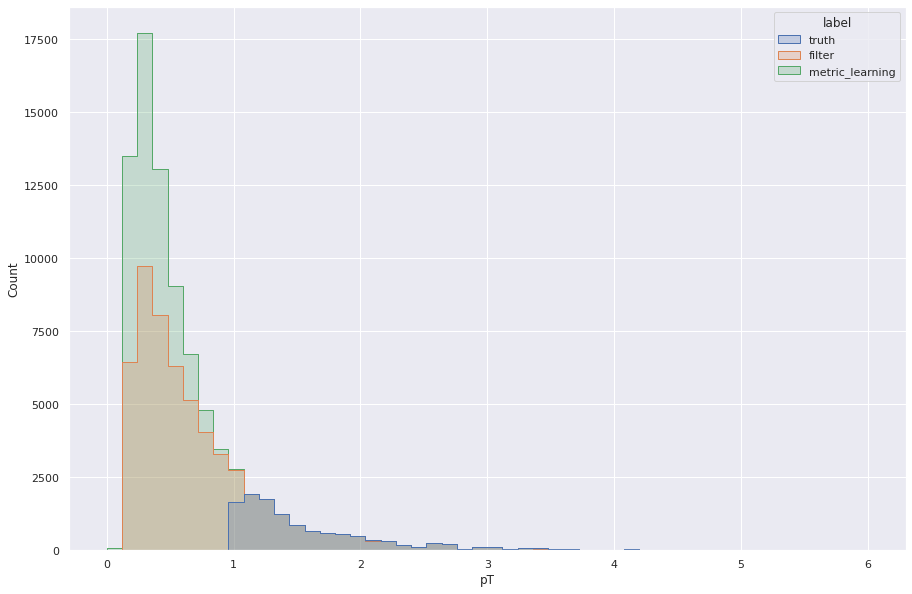

In [104]:
truth_pt = pd.DataFrame(dict(pT=filter_graph.pt[ filter_graph.signal_true_edges.flatten().unique() ].cpu().numpy()))
truth_pt['label'] = 'truth'
predicted_pt = pd.DataFrame(dict(pT=filter_graph.pt[ filter_graph.edge_index.flatten().unique() ].cpu().numpy()))
predicted_pt['label'] = 'filter'
ml_predicted_pt = pd.DataFrame(dict(pT=ml_graph.pt[ ml_graph.edge_index.flatten().unique() ].cpu().numpy()))
ml_predicted_pt['label'] = 'metric_learning'
pt = pd.concat([truth_pt, predicted_pt, ml_predicted_pt], ignore_index=True)
fig,ax = plt.subplots(1,1,figsize=(15,10))
plot_dict=dict(binrange=[0,6], stat='count', bins=50, element='step')
# ax = sns.histplot(data=pt[pt['label']=='Truth'], x='pT',  **plot_dict)
# sns.histplot(data=pt[pt['label']=='Predicted'], x='pT', **plot_dict)
sns.histplot(data=pt, x='pT', hue='label',ax=ax, **plot_dict)
# sns.histplot(x=predicted_pt, label='Predicted', **plot_dict, ax=ax)
plt.show()

## Plot truth long tracks and corresponding predicted tracks

In [117]:

p = figure(title='Truth graphs', x_axis_label='x', y_axis_label='y', height=800, width=800) 
q = figure(title='Filter graphs', x_axis_label='x', y_axis_label='y', height=800, width=800) 
s = figure(title='ML graphs', x_axis_label='x', y_axis_label='y', height=800, width=800) 

true_edges = torch.cat( [filter_graph.signal_true_edges, filter_graph.signal_true_edges.flip(0)], axis=1 )
true_unique, true_lengths = filter_graph.pid[true_edges[0]].unique(return_counts=True)
pred_edges = torch.cat( [filter_graph.edge_index, filter_graph.edge_index.flip(0)], axis=1 )
ml_pred_edges = torch.cat( [ml_graph.edge_index, ml_graph.edge_index.flip(0)], axis=1 )
pid = filter_graph.pid
r, phi, z = filter_graph.cpu().x.T
x, y = r * torch.cos(phi * np.pi), r * torch.sin(phi * np.pi)
cmap = viridis(16)
source = ColumnDataSource(dict(x=x.numpy(), y=y.numpy()))
p.circle(x='x', y='y', source=source, color=cmap[0], size=1, alpha=0.1)
q.circle(x='x', y='y', source=source, color=cmap[0], size=1, alpha=0.1)
s.circle(x='x', y='y', source=source, color=cmap[0], size=1, alpha=0.1)

long_tracks = true_unique[true_lengths >= 10]

for i, track in enumerate(long_tracks[ torch.randint(long_tracks.shape[0], (15,)) ]):
    
    # Get true track plot
    track_true_edges = true_edges[:, pid[ true_edges[0]] == track ]
    X_edges, Y_edges = x[track_true_edges].numpy(), y[track_true_edges].numpy()
    X = np.concatenate(X_edges)
    Y = np.concatenate(Y_edges)

    p.circle(X, Y, color=cmap[i], size=5)
    p.multi_line(X_edges.T.tolist(), Y_edges.T.tolist())

    track_pred_edges = pred_edges[:, (pid[pred_edges] == track).any(0)]

    X_edges, Y_edges = x[track_pred_edges].numpy(), y[track_pred_edges].numpy()
    X = np.concatenate(X_edges)
    Y = np.concatenate(Y_edges)

    q.circle(X, Y, color=cmap[i], size=5)
    q.multi_line(X_edges.T.tolist(), Y_edges.T.tolist())

    track_pred_edges = ml_pred_edges[:, (pid[ml_pred_edges] == track).any(0)]

    X_edges, Y_edges = x[track_pred_edges].numpy(), y[track_pred_edges].numpy()
    X = np.concatenate(X_edges)
    Y = np.concatenate(Y_edges)

    s.circle(X, Y, color=cmap[i], size=5)
    s.multi_line(X_edges.T.tolist(), Y_edges.T.tolist())
    
show(row([s,q, p]))

## Plot number of track edges

In [127]:
_, truth_edge_numbers = filter_graph.pid[filter_graph.modulewise_true_edges[0]].unique(return_counts=True)
truth_edge_numbers = pd.DataFrame(dict(edge_number=truth_edge_numbers))
truth_edge_numbers['label'] = 'Truth'
_, ml_predicted_edge_numbers = ml_graph.pid[ml_graph.edge_index[0]].unique(return_counts=True)
ml_predicted_edge_numbers = pd.DataFrame(dict(edge_number=ml_predicted_edge_numbers.cpu().numpy()))
ml_predicted_edge_numbers['label'] = 'Metric Learning'
_, filter_edge_numbers = filter_graph.pid[filter_graph.edge_index[0]].unique(return_counts=True)
filter_edge_numbers = pd.DataFrame(dict(edge_number=filter_edge_numbers))
filter_edge_numbers['label'] = 'Filter'

edge_numbers = pd.concat([truth_edge_numbers, ml_predicted_edge_numbers, filter_edge_numbers], ignore_index=True)

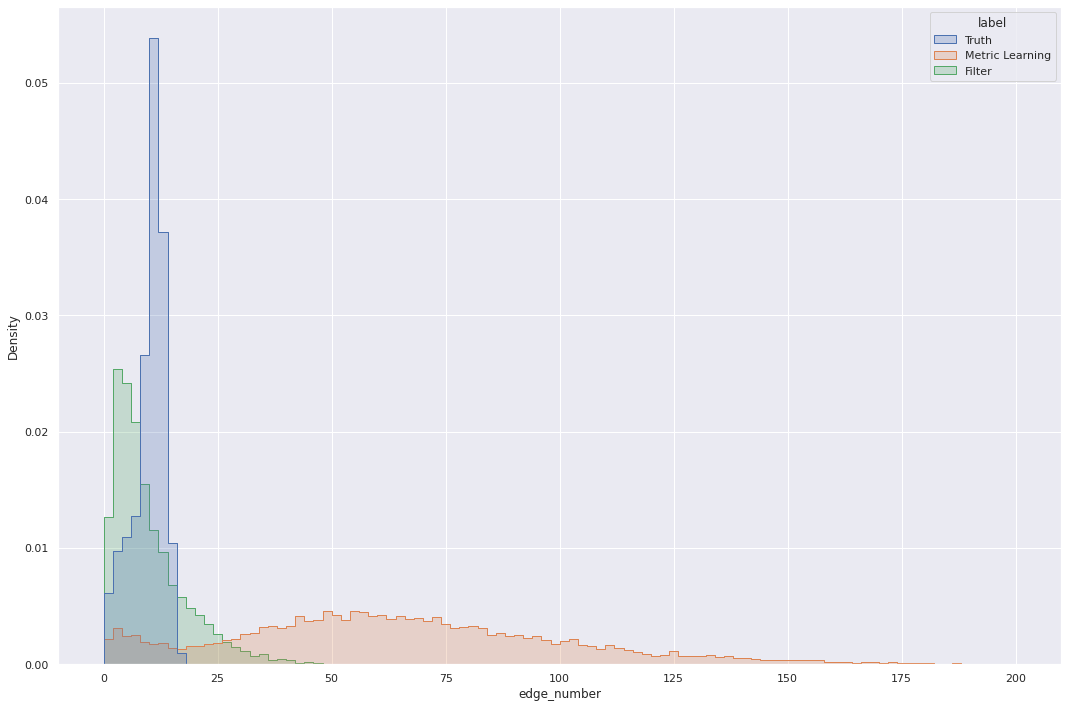

In [132]:
fig,ax = plt.subplots(1,1,figsize=(15,10))
plot_dict=dict(binrange=[0,200], stat='density', bins=100, element='step')

sns.histplot(data=edge_numbers, x='edge_number', hue='label',ax=ax, **plot_dict)
plt.tight_layout()
plt.savefig('edge_number_hist.png')
plt.show()